In [1]:
## import required packages
import numpy as np
import pandas as pd
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import missingno as ms 

In [2]:
## import complete dataset with all variables merged into a single file
df=pd.read_csv('combined_data.csv')


/Users/mkbelay/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
## check dimensions
df.shape

(65345, 25)

In [4]:
## check missingness
df.isna().sum()

state                        0
mrfei                     1221
fips_modified                0
NAME                     14591
perc_public_transport    14591
perc_white               14534
perc_black               14534
perc_hispanic            14534
perc_asian               14534
perc_native              14534
perc_pacific             14534
median_income            14671
SQMI                     14537
pop_density              14537
perc_pov                 14607
perc_snap                14622
inequality               14648
unemploy                 14591
below_high_school        14539
college_no_degree        14539
associates_degree        14539
bach_or_more             14539
value                    15060
perc_no_vehicle          14622
perc_rural               14503
dtype: int64

In [5]:
## save missingness output as csv for use in report
missingness=df.drop(columns=['state', 'fips_modified','NAME']).isna().sum()
missingness.to_csv('output/tables/missingness.csv')

In [6]:
## remove all observations with missing values 
df=df.dropna()
df.shape

(49561, 25)

In [7]:
## view dtypes
df.dtypes

state                     object
mrfei                     object
fips_modified             object
NAME                      object
perc_public_transport    float64
perc_white               float64
perc_black               float64
perc_hispanic            float64
perc_asian               float64
perc_native              float64
perc_pacific             float64
median_income            float64
SQMI                     float64
pop_density              float64
perc_pov                 float64
perc_snap                float64
inequality               float64
unemploy                 float64
below_high_school        float64
college_no_degree        float64
associates_degree        float64
bach_or_more             float64
value                    float64
perc_no_vehicle          float64
perc_rural               float64
dtype: object

In [8]:
## convert mrfei to float dtype
df['mrfei']=pd.to_numeric(df['mrfei'], errors='coerce')

In [9]:
## export descriptive statistics as a csv
df.describe().to_csv("output/tables/descriptive_stats.csv")

### Outcome variable: mRFEI Index

In [10]:
## generate descriptives
df.mrfei.describe()

count    49561.000000
mean        11.279686
std         11.976780
min          0.000000
25%          3.125000
50%          9.090909
75%         15.384615
max        100.000000
Name: mrfei, dtype: float64

There will be three separate categorical outcome variables generated from the continious mrfei variable. As such, there will be three separate modeling attempts for each outcome varaible. The first outcome will have a value of 1 if the tracts is a desert and a value of 0 if it is healthful. Desert tracts have an mrfei of 0 and healthful tracts have a mrfei greater than 9.09 (i.e, the median mrfei). Note that tracts with an mrfei greater than 0 and less than or equal to 9.09 will be excluded from the sample. The second outcome will have a value of 1 if the tracts is a swamp (i.e, mrfei >0 & <=9.09) and a value of 0 if a tract is healthful (i.e, mrfei>9.09). Desert swamps will be excluded from the sample. The last outcome will have a value of 1 if the tracts is a desert and a value of zero if the tract is a swamp. Healthful tracts are not included in the sample. 

**`Features`**: all missing values have been removed to prep the data for logistic regression. Let's look at the distribution of the data to see if any transformations need to be applied and the extent to which outliers are present. 

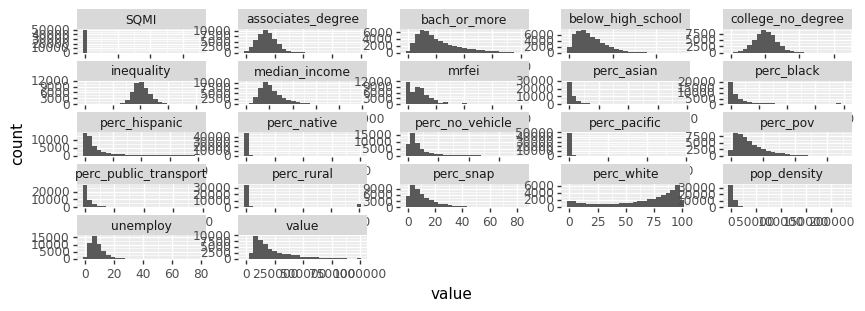

<ggplot: (8787458361420)>

In [11]:
## check distribution of features
df_for_graph=df.drop(columns=['NAME', 'fips_modified']).melt(id_vars='state')
(ggplot(df_for_graph,aes(x='value'))+geom_histogram(bins=25)+facet_wrap('variable', scales='free')+
 theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25}))

There are a substantial amount of attributes with pronounced skews. Lets see if we can transform them by taking the log.

In [12]:
df_for_graph=df
df_for_graph[['log_SQMI', 'log_perc_asian', 'log_perc_black', 'log_perc_hispanic', 'log_perc_native', 'log_perc_no_vehicle', 'log_perc_pacific', 'log_perc_public_transport', 'log_perc_rural', 'log_pop_density', 'log_perc_unemploy', 'log_bach_or_more', 'log_below_high_school', 'log_perc_pov','log_perc_snap', 'log_value']]=np.log(df_for_graph[['SQMI', 'perc_asian', 'perc_black', 'perc_hispanic', 'perc_native', 'perc_no_vehicle', 'perc_pacific', 'perc_public_transport', 'perc_rural', 'pop_density', 'unemploy','bach_or_more', 'below_high_school', 'perc_pov','perc_snap', 'value']]+1)

In [13]:
df_for_graph=df_for_graph.filter(['log_SQMI', 'log_perc_asian', 'log_perc_black', 'log_perc_hispanic', 'log_perc_native', 'log_perc_no_vehicle', 'log_perc_pacific', 'log_perc_public_transport', 'log_perc_rural', 'log_pop_density', 'log_perc_unemploy', 'log_bach_or_more', 'log_below_high_school', 'log_perc_pov','log_perc_snap', 'log_value'])

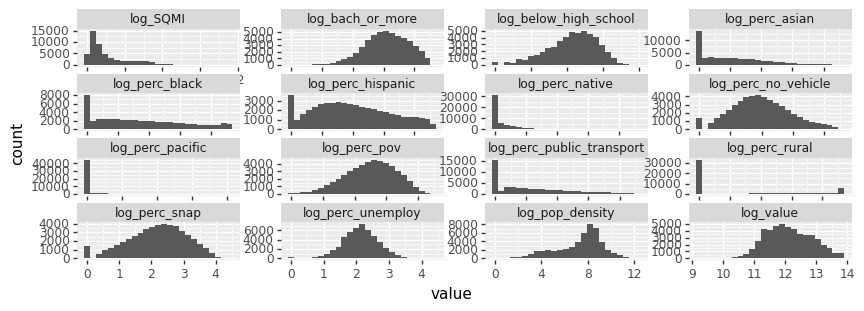

<ggplot: (8787458965547)>

In [14]:
df_for_graph=df_for_graph.melt()
(ggplot(df_for_graph,aes(x='value'))+geom_histogram(bins=25)+facet_wrap('variable', scales='free')+
 theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25}))

log_perc_asian, log_perc_black, log_perc_native, log_perc_pacific, log_perc_public_transport, and log_perc_rural still have skewed distributions but there is a bit more variability introduced. While most of the skewedness was remedied by applying log transformations, there were still a few variables that remained unchanged. Ideally, it would be better to convert these continuous attributes into categorical ones by creating cutoff within the distribution or converting them to binary attributes. This would perhaps improve the accuracy of the models used by eliminating the effects of outliers or skewedness. However, doing so would have implications for interpretability. Additionally, determining the appropriate cutoff for attributes that have more variability but are still skewed would be difficult. For these reasons, and to align with Amin etal’s design process, the skewed distribution will only be log transformed. 

In [15]:
## modify original dataframe to include the log transformed versions of the above attributes
df[['log_SQMI', 'log_perc_asian', 'log_perc_black', 'log_perc_hispanic', 'log_perc_native', 'log_perc_no_vehicle', 'log_perc_pacific', 'log_perc_public_transport', 'log_perc_rural', 'log_pop_density', 'log_perc_unemploy', 'log_bach_or_more', 'log_below_high_school', 'log_perc_pov','log_perc_snap', 'log_value']]=np.log(df[['SQMI', 'perc_asian', 'perc_black', 'perc_hispanic', 'perc_native', 'perc_no_vehicle', 'perc_pacific', 'perc_public_transport', 'perc_rural', 'pop_density', 'unemploy','bach_or_more', 'below_high_school', 'perc_pov','perc_snap', 'value']]+1)

In [16]:
## remove original columns
df=df.drop(columns=['SQMI', 'perc_asian', 'perc_black', 'perc_hispanic', 'perc_native', 'perc_no_vehicle', 'perc_pacific', 'perc_public_transport', 'perc_rural', 'pop_density', 'unemploy','bach_or_more', 'below_high_school', 'perc_pov','perc_snap', 'value'])

In [17]:
##check columns
df.columns

Index(['state', 'mrfei', 'fips_modified', 'NAME', 'perc_white',
       'median_income', 'inequality', 'college_no_degree', 'associates_degree',
       'log_SQMI', 'log_perc_asian', 'log_perc_black', 'log_perc_hispanic',
       'log_perc_native', 'log_perc_no_vehicle', 'log_perc_pacific',
       'log_perc_public_transport', 'log_perc_rural', 'log_pop_density',
       'log_perc_unemploy', 'log_bach_or_more', 'log_below_high_school',
       'log_perc_pov', 'log_perc_snap', 'log_value'],
      dtype='object')

In [18]:
## remove perc_white variable to avoid multicollinearity; remove fips modified; name; and state
df=df.drop(columns=['perc_white', 'NAME', 'state', 'fips_modified'])

In [19]:
## check shape
df.shape

(49561, 21)

**`Outcome 1: Desert vs. Healthful`**

In [20]:
## create dataframe with observations that have mrefi value ==0 | >9.09
d_vs_h=df.loc[(df['mrfei']==0) | (df['mrfei']>9.09)]
d_vs_h.shape

(37447, 21)

In [21]:
##confirm that swamps are removed from the dataframe
d_vs_h.loc[(d_vs_h['mrfei']>0) & (d_vs_h['mrfei']<=9.09)]

,mrfei,median_income,inequality,college_no_degree,associates_degree,log_SQMI,log_perc_asian,log_perc_black,log_perc_hispanic,log_perc_native,...,log_perc_pacific,log_perc_public_transport,log_perc_rural,log_pop_density,log_perc_unemploy,log_bach_or_more,log_below_high_school,log_perc_pov,log_perc_snap,log_value


In [22]:
##create a binary variable differenciating deserts and healthful tracts
d_vs_h.loc[d_vs_h['mrfei']==0, 'desert']=1
d_vs_h.loc[d_vs_h['mrfei']>9.09, 'desert']=0
d_vs_h['desert'].isna().sum()

/Users/mkbelay/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mkbelay/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:850: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
/Users/mkbelay/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: h

0

In [23]:
## drop continious mrfei variable
d_vs_h=d_vs_h.drop(columns=['mrfei'])
d_vs_h

,median_income,inequality,college_no_degree,associates_degree,log_SQMI,log_perc_asian,log_perc_black,log_perc_hispanic,log_perc_native,log_perc_no_vehicle,...,log_perc_public_transport,log_perc_rural,log_pop_density,log_perc_unemploy,log_bach_or_more,log_below_high_school,log_perc_pov,log_perc_snap,log_value,desert
0,70222.0,0.513,17.7,6.0,1.564441,0.000000,2.844723,0.603872,0.000000,2.102170,...,1.731861,2.869704,6.172893,1.568616,3.273364,2.442347,2.442611,1.909117,11.701072,0.0
1,41091.0,0.386,17.2,3.3,0.828552,1.124672,4.096981,0.260077,0.000000,2.818603,...,0.000000,0.000000,7.356849,2.186051,3.321432,2.766319,2.757414,2.292950,11.838633,0.0
2,44031.0,0.405,25.0,8.5,1.121678,0.248614,2.867678,0.742300,0.000000,2.180158,...,0.646009,0.000000,7.445765,1.902108,2.856470,2.351375,2.201493,2.371412,11.619994,0.0
3,56627.0,0.357,24.5,6.5,1.238374,0.331145,1.198171,1.293254,0.000000,0.709596,...,0.000000,0.000000,7.589088,1.704748,3.269569,1.974081,1.990926,2.039715,11.746423,0.0
5,45313.0,0.447,27.8,2.7,1.413423,0.000000,2.870014,1.579118,0.567729,1.144437,...,0.000000,1.095335,6.998410,2.208274,3.214868,2.351375,2.444364,2.399284,11.614588,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65340,53686.0,0.502,21.1,7.0,7.712752,0.490365,0.308707,2.367858,0.894722,0.841155,...,0.313587,4.443061,0.909913,1.704748,3.421000,2.174752,1.228137,2.059563,12.100718,1.0
65341,40304.0,0.403,23.1,10.0,0.570980,0.000000,0.000000,3.000891,0.000000,1.803092,...,0.000000,0.000000,8.234096,1.902108,2.856470,2.292535,2.349874,2.691720,11.350418,0.0
65342,56086.0,0.407,26.6,5.5,1.981001,1.064593,0.995036,2.044057,0.000000,1.906041,...,0.000000,2.462966,5.797516,1.252763,3.317816,2.116256,1.827912,0.000000,12.000898,0.0
65343,52440.0,0.437,24.4,7.6,7.765620,0.000000,0.127358,1.400204,0.557917,1.559998,...,2.038641,4.615121,0.810666,1.526056,2.949688,2.104134,2.162111,0.846403,11.788289,0.0


/Users/mkbelay/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 17'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


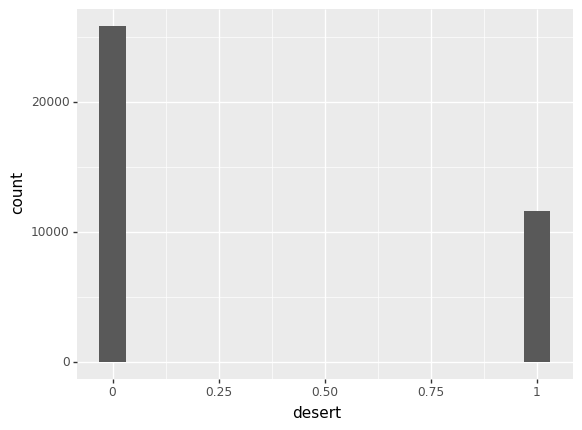

<ggplot: (8787458965730)>

In [24]:
## check distribution of outcome
(ggplot(d_vs_h, aes(x='desert'))+geom_histogram())

There is some imbalance. Let's make sure that the proprtion of observations that are deserts is not less than 10-20%.

In [25]:
## total number of observations
### number of observations classified as deserts
#d_vs_h.filter(['state', 'NAME']).loc[d_vs_h['desert']==1].count()
d_vs_h['desert'].value_counts()

0.0    25840
1.0    11607
Name: desert, dtype: int64

Approximately 30% (i.e, 11,607/37, 447) of the census tracts are deserts. To remedy this, the authors used an adaptive synthetic sampling method. This technique will be applied right after splitting the data into target and feature set.

**`Outcome 2: Swamp vs. Healthful`**

In [26]:
## create dataframe with observations that have mrefi value >0 
s_vs_h=df.loc[df['mrfei']>0]
s_vs_h.shape

(37954, 21)

In [27]:
##confirm that deserts are removed from the dataframe
s_vs_h.loc[s_vs_h['mrfei']==0]

,mrfei,median_income,inequality,college_no_degree,associates_degree,log_SQMI,log_perc_asian,log_perc_black,log_perc_hispanic,log_perc_native,...,log_perc_pacific,log_perc_public_transport,log_perc_rural,log_pop_density,log_perc_unemploy,log_bach_or_more,log_below_high_school,log_perc_pov,log_perc_snap,log_value


In [28]:
##create a binary variable differenciating swamps and healthful tracts
s_vs_h.loc[s_vs_h['mrfei']<=9.09, 'swamp']=1
s_vs_h.loc[s_vs_h['mrfei']>9.09, 'swamp']=0
s_vs_h['swamp'].isna().sum()

/Users/mkbelay/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mkbelay/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:850: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
/Users/mkbelay/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: h

0

In [29]:
## drop continious mrfei variable
s_vs_h=s_vs_h.drop(columns=['mrfei'])
s_vs_h

,median_income,inequality,college_no_degree,associates_degree,log_SQMI,log_perc_asian,log_perc_black,log_perc_hispanic,log_perc_native,log_perc_no_vehicle,...,log_perc_public_transport,log_perc_rural,log_pop_density,log_perc_unemploy,log_bach_or_more,log_below_high_school,log_perc_pov,log_perc_snap,log_value,swamp
0,70222.0,0.513,17.7,6.0,1.564441,0.000000,2.844723,0.603872,0.000000,2.102170,...,1.731861,2.869704,6.172893,1.568616,3.273364,2.442347,2.442611,1.909117,11.701072,0.0
1,41091.0,0.386,17.2,3.3,0.828552,1.124672,4.096981,0.260077,0.000000,2.818603,...,0.000000,0.000000,7.356849,2.186051,3.321432,2.766319,2.757414,2.292950,11.838633,0.0
2,44031.0,0.405,25.0,8.5,1.121678,0.248614,2.867678,0.742300,0.000000,2.180158,...,0.646009,0.000000,7.445765,1.902108,2.856470,2.351375,2.201493,2.371412,11.619994,0.0
3,56627.0,0.357,24.5,6.5,1.238374,0.331145,1.198171,1.293254,0.000000,0.709596,...,0.000000,0.000000,7.589088,1.704748,3.269569,1.974081,1.990926,2.039715,11.746423,0.0
4,68317.0,0.334,22.4,6.7,1.690096,1.004569,2.532252,1.747352,0.183361,1.940319,...,0.000000,0.036480,7.718426,1.547563,3.650658,1.335001,1.939739,1.556525,12.061053,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65339,52949.0,0.388,30.3,6.1,4.013677,0.026840,0.039995,2.525206,0.000000,1.382970,...,0.779830,2.988497,4.914648,1.871802,2.791165,2.312535,2.466988,2.294886,12.003963,0.0
65341,40304.0,0.403,23.1,10.0,0.570980,0.000000,0.000000,3.000891,0.000000,1.803092,...,0.000000,0.000000,8.234096,1.902108,2.856470,2.292535,2.349874,2.691720,11.350418,0.0
65342,56086.0,0.407,26.6,5.5,1.981001,1.064593,0.995036,2.044057,0.000000,1.906041,...,0.000000,2.462966,5.797516,1.252763,3.317816,2.116256,1.827912,0.000000,12.000898,0.0
65343,52440.0,0.437,24.4,7.6,7.765620,0.000000,0.127358,1.400204,0.557917,1.559998,...,2.038641,4.615121,0.810666,1.526056,2.949688,2.104134,2.162111,0.846403,11.788289,0.0


/Users/mkbelay/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 17'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


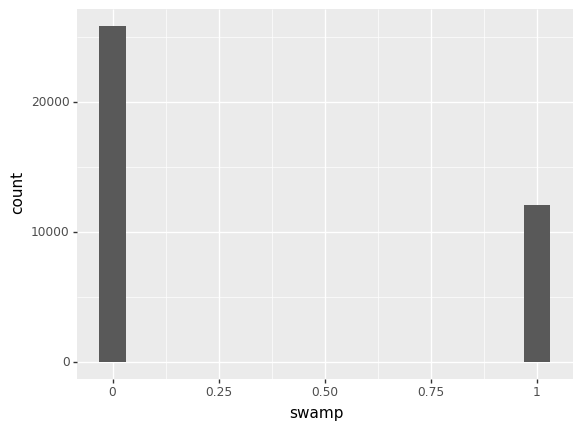

<ggplot: (8787458714709)>

In [30]:
## check distribution of outcome
(ggplot(s_vs_h, aes(x='swamp'))+geom_histogram())

There is some imbalance. Let's make sure that the proprtion of observations that are deserts is not less than 10-20%.

In [31]:
## total number of observations
### number of observations classified as deserts
#d_vs_h.filter(['state', 'NAME']).loc[d_vs_h['desert']==1].count()
s_vs_h['swamp'].value_counts()

0.0    25840
1.0    12114
Name: swamp, dtype: int64

Approximately 32% (i.e, 12,114/37,954) of the census tracts are deserts. To remedy this, the authors used an adaptive synthetic sampling method. This technique will be applied right after splitting the data into target and feature set.

**`Outcome 3: Desert vs. Swamp`**

In [32]:
## create dataframe with observations that have mrefi value >0 
d_vs_s=df.loc[(df['mrfei']==0) | (df['mrfei']<=9.09)]
d_vs_s.shape

(23721, 21)

In [33]:
##confirm that healthful tracts are removed from the dataframe
d_vs_s.loc[d_vs_s['mrfei']>9.09]

,mrfei,median_income,inequality,college_no_degree,associates_degree,log_SQMI,log_perc_asian,log_perc_black,log_perc_hispanic,log_perc_native,...,log_perc_pacific,log_perc_public_transport,log_perc_rural,log_pop_density,log_perc_unemploy,log_bach_or_more,log_below_high_school,log_perc_pov,log_perc_snap,log_value


In [34]:
##create a binary variable differenciating swamps and deserts
d_vs_s.loc[d_vs_s['mrfei']==0, 'desert']=1
d_vs_s.loc[d_vs_s['mrfei']!=0, 'desert']=0
d_vs_s['desert'].isna().sum()

/Users/mkbelay/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mkbelay/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:850: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
/Users/mkbelay/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: h

0

In [35]:
## drop continious mrfei variable
d_vs_s=d_vs_s.drop(columns=['mrfei'])
d_vs_s

,median_income,inequality,college_no_degree,associates_degree,log_SQMI,log_perc_asian,log_perc_black,log_perc_hispanic,log_perc_native,log_perc_no_vehicle,...,log_perc_public_transport,log_perc_rural,log_pop_density,log_perc_unemploy,log_bach_or_more,log_below_high_school,log_perc_pov,log_perc_snap,log_value,desert
4,68317.0,0.334,22.4,6.7,1.690096,1.004569,2.532252,1.747352,0.183361,1.940319,...,0.000000,0.036480,7.718426,1.547563,3.650658,1.335001,1.939739,1.556525,12.061053,0.0
8,48500.0,0.380,21.2,6.0,4.738214,0.424680,2.478944,0.526682,0.424680,1.359836,...,0.000000,4.615121,3.900070,2.302585,2.624669,2.721295,2.389400,2.729332,11.589896,1.0
10,40078.0,0.426,13.5,8.7,5.252692,0.415722,4.070917,0.780487,0.000000,2.429680,...,0.786553,4.615121,2.909662,2.985682,2.341806,3.100092,2.945013,2.644495,11.211834,1.0
11,39099.0,0.378,16.6,8.5,5.967658,0.000000,2.894239,0.000000,0.934791,0.570241,...,0.000000,4.615121,2.315259,1.547563,2.406945,2.862201,1.423013,2.297049,11.468984,1.0
12,42406.0,0.331,24.3,9.2,4.461184,0.000000,2.222593,0.651719,1.108264,1.610183,...,0.000000,4.553195,3.450546,1.774952,2.174752,2.862201,1.840153,2.122942,11.544434,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65326,53644.0,0.356,28.1,7.2,3.991389,0.299710,0.550362,3.006706,0.498660,1.244050,...,0.483513,2.655601,4.688747,2.230014,2.197225,2.282382,2.618619,1.311719,11.248973,1.0
65331,65335.0,0.375,33.6,5.7,1.726332,0.607596,0.456651,2.574304,0.176409,2.209767,...,1.970710,0.113727,6.513468,1.974081,2.653242,2.014903,1.884865,1.309556,11.944714,1.0
65332,84583.0,0.362,24.8,10.6,2.672768,1.145918,0.000000,2.513614,0.000000,0.844262,...,1.735278,0.000000,5.372458,1.280934,3.391147,1.589235,1.928961,0.633489,12.272333,1.0
65333,73044.0,0.432,31.4,6.7,9.013008,0.060042,0.000000,2.215754,0.116682,0.000000,...,0.000000,4.615121,0.179715,1.840550,2.815409,2.116256,1.955062,0.640200,11.254168,1.0


/Users/mkbelay/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 15'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


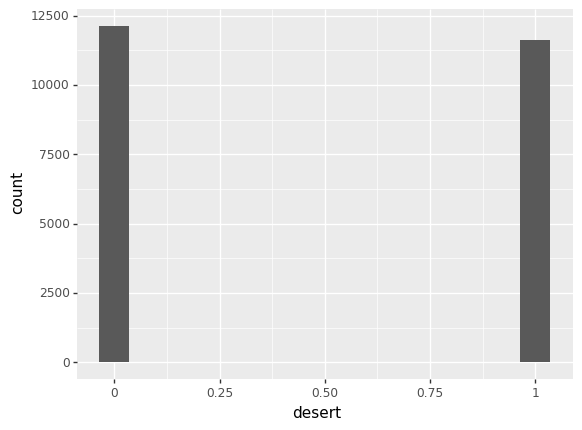

<ggplot: (8787459432099)>

In [36]:
## check distribution of outcome
(ggplot(d_vs_s, aes(x='desert'))+geom_histogram())

Unlike the previous outcomes, desert and swamps are balanced.

In [37]:
## total number of observations
### number of observations classified as deserts
#d_vs_h.filter(['state', 'NAME']).loc[d_vs_h['desert']==1].count()
d_vs_s['desert'].value_counts()

0.0    12114
1.0    11607
Name: desert, dtype: int64

Approximately 48% (i.e, 11607/23721) of the census tracts are deserts. Oversampling techniques don't need to be used for this outcome

## Modeling 

In [38]:
## import sckit-learn packages
## split and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

##Modeling
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression,Lasso
from sklearn.metrics import mean_squared_error, confusion_matrix

from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import recall_score, f1_score

from sklearn.metrics import roc_curve, precision_recall_curve, auc, log_loss

**`Outcome 1: Desert vs. Healthful`**

In [39]:
## separate outcome from features
y=d_vs_h['desert']
X=d_vs_h.drop(columns=['desert'])
X.shape

(37447, 20)

In [40]:
# standardize features to eliminate issues of scaling
scaler = StandardScaler()
Xsc = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
Xsc.head(2)

,median_income,inequality,college_no_degree,associates_degree,log_SQMI,log_perc_asian,log_perc_black,log_perc_hispanic,log_perc_native,log_perc_no_vehicle,log_perc_pacific,log_perc_public_transport,log_perc_rural,log_pop_density,log_perc_unemploy,log_bach_or_more,log_below_high_school,log_perc_pov,log_perc_snap,log_value
0,0.529824,1.723919,-0.460125,-0.439453,-0.197562,-0.961103,0.910744,-1.021402,-0.519756,0.292217,-0.238775,0.737505,0.734790,-0.345191,-0.966555,0.266485,0.483545,0.001161,-0.223380,-0.538513
1,-0.549068,-0.376655,-0.542228,-1.265031,-0.627290,0.162290,1.817816,-1.304535,-0.519756,1.110908,-0.238775,-0.906058,-0.752209,0.215664,0.174657,0.335351,0.957642,0.403300,0.206779,-0.350010


In [41]:
## split data; test size is 30% [this was selected to follow what Amin et. al did]
Xtrain, Xtest, ytrain, ytest = train_test_split(Xsc, y, test_size=0.3, random_state=10)

**`Logistic Regression`**

In [42]:
## oversample minority class (i.e, desert)
ada=ADASYN(random_state=420)
X_ada, y_ada = ada.fit_resample(Xtrain, ytrain)
print('Resampled dataset after ADASYN %s' % y_ada.value_counts())

Resampled dataset after ADASYN 1.0    19037
0.0    18062
Name: desert, dtype: int64


In [43]:
## fit logistic model on resampled set
ada_logit = LogisticRegression()
ada_logit.fit(X_ada, y_ada)

LogisticRegression()

In [44]:
# examine classification errors on test set
print('Accuracy:', ada_logit.score(Xtest, ytest))
print('Recall:', recall_score (ytest, ada_logit.predict(Xtest)))
confusion_matrix(ytest, ada_logit.predict(Xtest))

Accuracy: 0.5838006230529595
Recall: 0.6829621058721435


array([[4198, 3580],
       [1096, 2361]])

The overall accuracy of the logistic regression model is about 0.58. This is just barely better than a coin flip, indicating there is high bias in the data. Conversely, the sensitivity/recall is about 0.68 (i.e., out of all deserts, the model correctly classified approximately 68% as deserts; the remaining 32% were misclassified as healthful tracts). The accuracy is quite low; it wasn't exceptionally good in the previous iteratio either. There is a substantial amount of bias in the data. Next we will see how a LASSO logistic regression will perform in the oversampled data sets. The bias should become worse [given that coefficients are being shrunk to zero], but we will at least be able to compare the coefficient estimates from the two models for inference purposes.

`LASSO oversampling`

In [45]:
##fit lasso logistic regression using resampled dataset
ada_lasso = LogisticRegression(penalty= 'l1', solver= 'liblinear',random_state=10)
ada_lasso.fit(X_ada, y_ada)

LogisticRegression(penalty='l1', random_state=10, solver='liblinear')

In [46]:
## specify range for alpha/C
C=np.arange(0.001,0.03,0.005)
C

array([0.001, 0.006, 0.011, 0.016, 0.021, 0.026])

#### Validation Curve: hyper parameter turning for strength of regularization penalty

In [47]:
## generate training and test scores using cv 10 fold
train_scores, test_scores = validation_curve(ada_lasso, X_ada, y_ada, param_name='C',
                                            param_range=C, cv=10)
train_scores


array([[0.57186499, 0.57045734, 0.57171524, 0.57213454, 0.57447063,
        0.57509958, 0.57548893, 0.57599808, 0.57530923, 0.57637017],
       [0.58968523, 0.59073348, 0.59112282, 0.59079338, 0.59474677,
        0.59498637, 0.59501632, 0.59621432, 0.59645392, 0.59475891],
       [0.59573512, 0.59663362, 0.59747222, 0.59657372, 0.60070682,
        0.60154542, 0.60040732, 0.60175507, 0.60142562, 0.60110812],
       [0.59777172, 0.59884992, 0.59893977, 0.59893977, 0.60268352,
        0.60286322, 0.60190482, 0.60310282, 0.60271347, 0.60320455],
       [0.59887987, 0.59914942, 0.60001797, 0.59914942, 0.60316272,
        0.60364192, 0.60238402, 0.60457037, 0.60277337, 0.6033543 ],
       [0.59974842, 0.59986822, 0.60028752, 0.59968852, 0.60292312,
        0.60385157, 0.60316272, 0.60475007, 0.60298302, 0.60395328]])

In [48]:
## compute mean train and test scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_mean

array([0.57386951, 0.59222582, 0.59820977, 0.59977318, 0.60079743,
       0.60079738])

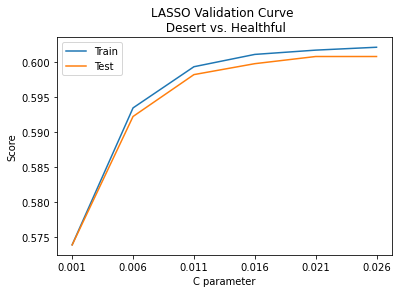

In [49]:
## plot curve
fig1 = plt.figure()
plt.plot(C, train_mean, label='Train')
plt.plot(C, test_mean, label='Test')
plt.xlabel('C parameter')
plt.ylabel('Score')
plt.title('LASSO Validation Curve \n Desert vs. Healthful')
plt.xticks(C)
plt.legend()
plt.savefig('output/images/valid_curve_lasso_desert_healthful.png')

Let's pick 0.021 as this is the point where the train and test are close to each other and the test score is the highest. After this point, the test score seems like it remains fairly constant.

In [50]:
## fit logistic model on resampled set
ada_lasso = LogisticRegression(C=0.021, penalty= 'l1', solver= 'liblinear',random_state=10)
ada_lasso.fit(X_ada, y_ada)

LogisticRegression(C=0.021, penalty='l1', random_state=10, solver='liblinear')

In [51]:
# examine classification errors
print('Accuracy:', ada_lasso.score(Xtest, ytest))
print('Recall: ', recall_score(ytest, ada_lasso.predict(Xtest)))
confusion_matrix(ytest, ada_lasso.predict(Xtest))

Accuracy: 0.585491766800178
Recall:  0.6789123517500724


array([[4231, 3547],
       [1110, 2347]])

The overall accuracy of the lasso is about the same as the logistic regression aat about 0.58. Again, there is clearly high bias in the data. The sensitivity/recall is slightly less than the logistic regresssion--recall that log. regression has a recall of 0.68 while lasso has 0.67. It seems like shrinking coefficients to zero didn't actually have an impact on the overall accuracy of the lasso. 

Let's compare the coefficient estimates from these two models.

In [52]:
x=pd.DataFrame({ 'Variable': X_ada.columns,'Logit Coef': ada_logit.coef_.ravel(), 'Lasso Coef': ada_lasso.coef_.ravel()})
x

,Variable,Logit Coef,Lasso Coef
0,median_income,0.246257,0.209327
1,inequality,-0.038200,-0.032318
2,college_no_degree,0.039135,0.030285
3,associates_degree,0.031149,0.022059
4,log_SQMI,-0.995184,-0.719493
5,log_perc_asian,-0.088051,-0.089394
6,log_perc_black,0.124046,0.122393
7,log_perc_hispanic,-0.065865,-0.072861
8,log_perc_native,-0.000162,0.000000
9,log_perc_no_vehicle,-0.169864,-0.160560


In [53]:
## rename variables
x=x.replace({'median_income':'Median income', 'inequality':'Inequality', 'college_no_degree':'College no degree', 'associates_degree':'Some college','log_SQMI': 'Land area', 'log_perc_asian': 'Asian', 'log_perc_black':'Black', 'log_perc_hispanic':'Hispanic', 'log_perc_native':'Alaska Native', 'log_perc_pacific':'Pacific Islander', 'log_perc_public_transport':'Public transport', 'log_perc_rural': 'Rural', 'log_pop_density':'Population density', 'log_perc_unemploy':'Unemployment', 'log_bach_or_more':'Bachelors or more', 'log_below_high_school':'Below high school', 'log_perc_pov':'Poverty rate', 'log_perc_snap':'HH with SNAP', 'log_value': 'Property value', 'log_perc_no_vehicle':'No vehicle'})

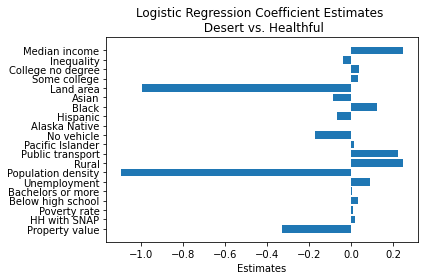

In [54]:
## plot coefficients for logit
fig, ax = plt.subplots()
ax.barh(x['Variable'],x['Logit Coef'], align='center')
ax.set_yticks(x['Variable'])
ax.invert_yaxis()  
ax.set_xlabel('Estimates')
ax.set_title('Logistic Regression Coefficient Estimates \n Desert vs. Healthful')
plt.tight_layout()
plt.savefig('output/images/logit_desert_healthful.png')

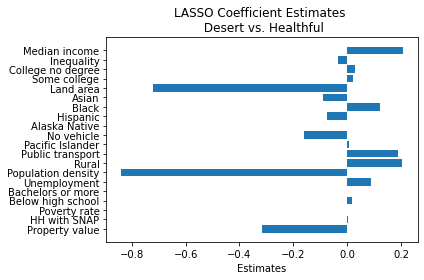

In [55]:
## plot lasso coefficient estimates
fig, ax = plt.subplots()
ax.barh(x['Variable'],x['Lasso Coef'], align='center')
ax.set_yticks(x['Variable'])
ax.invert_yaxis()  
ax.set_xlabel('Estimates')
ax.set_title('LASSO Coefficient Estimates \n Desert vs. Healthful')
plt.tight_layout()
plt.savefig('output/images/lasso_desert_healthful.png')

The actual estimates from both models are pretty similar. However, the log_per_native and log_perc_pov attributes were shrunk to zero in the lasso, but have a negative relationship and a positive relationship , respectively , with the outcome. In both models, median_income has the highest positive magnitude, followed by log_perc_public_transport. We also see that log_pop_density has the lowest/highest positive magnitude. 

`Random Forest : oversampling`

In [56]:
## fit logistic model on resampled set
ada_model = RandomForestClassifier()
ada_model.fit(X_ada, y_ada)

RandomForestClassifier()

In [57]:
# examine classification errors
print('Accuracy:', ada_model.score(Xtest, ytest))
print('Recall: ', recall_score(ytest, ada_model.predict(Xtest)))
confusion_matrix(ytest, ada_model.predict(Xtest))

Accuracy: 0.6731642189586114
Recall:  0.46977147816025455


array([[5939, 1839],
       [1833, 1624]])

Random forest has a  higher overall accuracy than lasso and logistic. However, the recall is especially poort at about 0.47. This means that only 47% of food desert census tracts were correctly classified as deserts. while the remaining 53% are misclassified as healthful tracts. 

In [58]:
## safe feature importance to dataframe
x=pd.DataFrame({'Variables':X_ada.columns, 'MDI':ada_model.feature_importances_})
x

,Variables,MDI
0,median_income,0.053477
1,inequality,0.051346
2,college_no_degree,0.051970
3,associates_degree,0.049944
4,log_SQMI,0.064150
5,log_perc_asian,0.047418
6,log_perc_black,0.056582
7,log_perc_hispanic,0.055913
8,log_perc_native,0.033474
9,log_perc_no_vehicle,0.055856


In [59]:
## rename variables
x=x.replace({'median_income':'Median income', 'inequality':'Inequality', 'college_no_degree':'College no degree', 'associates_degree':'Some college','log_SQMI': 'Land area', 'log_perc_asian': 'Asian', 'log_perc_black':'Black', 'log_perc_hispanic':'Hispanic', 'log_perc_native':'Alaska Native', 'log_perc_pacific':'Pacific Islander', 'log_perc_public_transport':'Public transport', 'log_perc_rural': 'Rural', 'log_pop_density':'Population density', 'log_perc_unemploy':'Unemployment', 'log_bach_or_more':'Bachelors or more', 'log_below_high_school':'Below high school', 'log_perc_pov':'Poverty rate', 'log_perc_snap':'HH with SNAP', 'log_value': 'Property value', 'log_perc_no_vehicle':'No vehicle'})

In [60]:
x=x.sort_values('MDI', ascending=False)
x

,Variables,MDI
4,Land area,0.064150
13,Population density,0.063833
19,Property value,0.062641
6,Black,0.056582
7,Hispanic,0.055913
9,No vehicle,0.055856
0,Median income,0.053477
17,Poverty rate,0.052188
2,College no degree,0.051970
15,Bachelors or more,0.051477


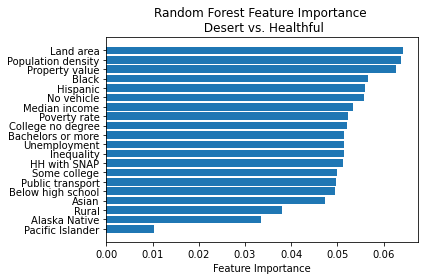

In [61]:
## plot lasso coefficient estimates
fig, ax = plt.subplots()
ax.barh(x['Variables'],x['MDI'], align='center')
ax.set_yticks(x['Variables'])
ax.invert_yaxis()  
ax.set_xlabel('Feature Importance')
ax.set_title('Random Forest Feature Importance \n Desert vs. Healthful')
plt.tight_layout()
plt.savefig('output/images/rf_desert_healthful.png')

In [62]:
## save overall accuracy and recall score from each model ; will be exported to csv
eval_1=pd.DataFrame({'Accuracy: RF':ada_model.score(Xtest, ytest), 'Recall: RF':recall_score(ytest,ada_model.predict(Xtest)), 'Accuracy:Lasso':ada_lasso.score(Xtest, ytest), 'Recall: Lasso':recall_score(ytest, ada_lasso.predict(Xtest)), 'Accuracy:Logit':ada_logit.score(Xtest, ytest), 'Recall: Logit':recall_score(ytest, ada_logit.predict(Xtest))}, index=[0])
eval_1

,Accuracy: RF,Recall: RF,Accuracy:Lasso,Recall: Lasso,Accuracy:Logit,Recall: Logit
0,0.673164,0.469771,0.585492,0.678912,0.583801,0.682962


  `Plot ROC AUC`

In [63]:
## save logistic predictions to object
y_pred = ada_logit.predict_proba(Xtest)

In [64]:
## generate true positives and false positives for KNN
false_positive_rate, true_positive_rate, thresholds = roc_curve(ytest, y_pred[:,1], pos_label=1)
logit_rates = pd.DataFrame(dict(fpr=false_positive_rate, tpr=true_positive_rate))
logit_auc = auc(logit_rates['fpr'], logit_rates['tpr'])
print('Logistic Regression AUC: ', logit_auc)

Logistic Regression AUC:  0.6657442168869971


In [65]:
## save lasso predictions to object
y_pred = ada_lasso.predict_proba(Xtest)

In [66]:
## generate true positives and false positives for log_reg
false_positive_rate, true_positive_rate, thresholds = roc_curve(ytest, y_pred[:,1], pos_label=1)
lasso_rates = pd.DataFrame(dict(fpr=false_positive_rate, tpr=true_positive_rate))
lasso_auc = auc(lasso_rates['fpr'], lasso_rates['tpr'])
print('LASSO AUC: ', lasso_auc)

LASSO AUC:  0.6662693103598833


In [67]:
## save NB predictions to object
y_pred = ada_model.predict_proba(Xtest)

In [68]:
## generate true positives and false positives for NB
false_positive_rate, true_positive_rate, thresholds = roc_curve(ytest, y_pred[:,1], pos_label=1)
random_forest_rates = pd.DataFrame(dict(fpr=false_positive_rate, tpr=true_positive_rate))
random_forest_auc = auc(random_forest_rates['fpr'], random_forest_rates['tpr'])
print('Random Forest AUC: ', random_forest_auc)

Random Forest AUC:  0.6771272608046564


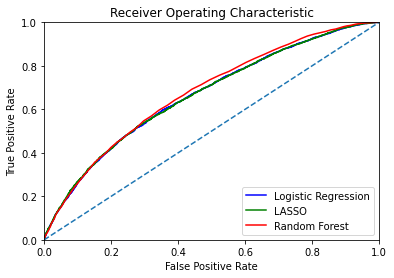

In [69]:
## plot ROC for KNN, log-reg, and NB
fig3 = plt.figure()
plt.plot(logit_rates.fpr, logit_rates.tpr, 'b', label = 'Logistic Regression')
plt.plot(lasso_rates.fpr, lasso_rates.tpr, 'g', label = 'LASSO')
plt.plot(random_forest_rates.fpr, random_forest_rates.tpr, 'r', label = 'Random Forest')
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

**`Outcome 2: Swamp vs. Healthful`**

In [70]:
## separate outcome from features
y=s_vs_h['swamp']
X=s_vs_h.drop(columns=['swamp'])
X.shape

(37954, 20)

In [71]:
# standardize features to eliminate issues of scaling
scaler = StandardScaler()
Xsc = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
Xsc.head(2)

,median_income,inequality,college_no_degree,associates_degree,log_SQMI,log_perc_asian,log_perc_black,log_perc_hispanic,log_perc_native,log_perc_no_vehicle,log_perc_pacific,log_perc_public_transport,log_perc_rural,log_pop_density,log_perc_unemploy,log_bach_or_more,log_below_high_school,log_perc_pov,log_perc_snap,log_value
0,0.572401,1.594824,-0.388015,-0.363446,0.094676,-1.079708,0.773453,-1.201958,-0.520845,0.059454,-0.245388,0.425575,1.209925,-0.747916,-1.029231,0.219925,0.449987,-0.087363,-0.271783,-0.652345
1,-0.512872,-0.449178,-0.468236,-1.197285,-0.417641,-0.005200,1.676932,-1.478981,-0.520845,0.825608,-0.245388,-1.022187,-0.562468,-0.118306,0.112936,0.287113,0.915056,0.311488,0.149784,-0.466822


In [72]:
## split data; test size is 30%
Xtrain, Xtest, ytrain, ytest = train_test_split(Xsc, y, test_size=0.3, random_state=10)

**`Logistic Regression`**

In [73]:
## oversample minority class (i.e, desert)
ada=ADASYN(random_state=420)
X_ada, y_ada = ada.fit_resample(Xtrain, ytrain)
print('Resampled dataset after ADASYN %s' % y_ada.value_counts())

Resampled dataset after ADASYN 1.0    18461
0.0    18177
Name: swamp, dtype: int64


In [74]:
## fit logistic model on resampled set
ada_logit = LogisticRegression()
ada_logit.fit(X_ada, y_ada)

LogisticRegression()

In [75]:
# examine classification errors
print('Accuracy:', ada_logit.score(Xtest, ytest))
print('Recall:',recall_score(ytest, ada_logit.predict(Xtest)))
confusion_matrix(ytest, ada_logit.predict(Xtest))

Accuracy: 0.6178097830859752
Recall: 0.7338882921589689


array([[4302, 3361],
       [ 991, 2733]])

The accuracy of the logistic regression model is about 0.62--this is a lot higher than when we had desert vs. healthful as the outcome. Additionally the recall is about 0.73 and is also higher than for outcome 1. Swamps are being detected and classified at a higer rate than deserts. The accuracy could also be because the attributes are more correlated with swamps rather than deserts.

`LASSO oversampling`

In [76]:
##fit lasso logistic regression using resampled dataset
ada_lasso = LogisticRegression(penalty= 'l1', solver= 'liblinear',random_state=10)
ada_lasso.fit(X_ada, y_ada)

LogisticRegression(penalty='l1', random_state=10, solver='liblinear')

In [77]:
## specify range for alpha/C
C=np.arange(0.001,0.03,0.005)
C

array([0.001, 0.006, 0.011, 0.016, 0.021, 0.026])

#### Validation Curve: hyper parameter turning for strength of regularization penalty

In [78]:
## generate training and test scores using cv 10 fold
train_scores, test_scores = validation_curve(ada_lasso, X_ada, y_ada, param_name='C',
                                            param_range=C, cv=10)
train_scores


array([[0.62227816, 0.62224783, 0.62112574, 0.62145933, 0.62488627,
        0.62470431, 0.6244617 , 0.62588706, 0.6255345 , 0.62398787],
       [0.62370352, 0.62370352, 0.6236732 , 0.62309699, 0.62679687,
        0.62622066, 0.62582641, 0.62767635, 0.6270508 , 0.62656558],
       [0.62306666, 0.62397647, 0.62285437, 0.62330927, 0.62679687,
        0.62706981, 0.62800995, 0.62746406, 0.62726308, 0.62674754],
       [0.62400679, 0.6244617 , 0.62246012, 0.62403712, 0.62731243,
        0.62822224, 0.62855583, 0.62837387, 0.62817286, 0.62759666],
       [0.62400679, 0.6249166 , 0.62282404, 0.62443137, 0.627737  ,
        0.62898041, 0.62982956, 0.62797962, 0.62877938, 0.62829416],
       [0.62437072, 0.62534118, 0.62352156, 0.62528052, 0.62770668,
        0.62907139, 0.63049676, 0.62888943, 0.62908264, 0.62826384]])

In [79]:
## compute mean train and test scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_mean

array([0.62293194, 0.62473294, 0.62481493, 0.62549729, 0.62587938,
       0.62680738])

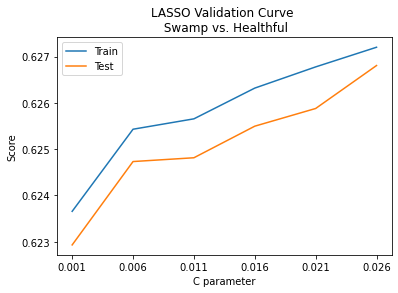

In [80]:
## plot curve
fig1 = plt.figure()
plt.plot(C, train_mean, label='Train')
plt.plot(C, test_mean, label='Test')
plt.xlabel('C parameter')
plt.ylabel('Score')
plt.title('LASSO Validation Curve \n Swamp vs. Healthful')
plt.xticks(C)
plt.legend()
plt.savefig('output/images/valid_curve_lasso_swamp_healthful.png')

let's pick 0.026 because that is the point where the train and test score are the closest and also where the test score is the highest.

In [81]:
## fit logistic model on resampled set
ada_lasso = LogisticRegression(C=0.026, penalty= 'l1', solver= 'liblinear',random_state=10)
ada_lasso.fit(X_ada, y_ada)
#print('Validation set Recall: ', 
      #recall_score(ytest, ada_model.predict(Xtest)))

LogisticRegression(C=0.026, penalty='l1', random_state=10, solver='liblinear')

In [82]:
# examine classification errors
print('Accuracy:', ada_lasso.score(Xtest, ytest))
print('Recall:',recall_score(ytest, ada_lasso.predict(Xtest)))
confusion_matrix(ytest, ada_lasso.predict(Xtest))

Accuracy: 0.6178097830859752
Recall: 0.7451664876476907


array([[4260, 3403],
       [ 949, 2775]])

In [83]:
x=pd.DataFrame({ 'Variable': X_ada.columns,'Logit Coef': ada_logit.coef_.ravel(), 'Lasso Coef': ada_lasso.coef_.ravel()})
x

,Variable,Logit Coef,Lasso Coef
0,median_income,0.016176,0.000000
1,inequality,0.068534,0.054079
2,college_no_degree,0.034661,0.020158
3,associates_degree,-0.031400,-0.026391
4,log_SQMI,0.274539,0.056706
5,log_perc_asian,0.027084,0.023217
6,log_perc_black,0.218652,0.222342
7,log_perc_hispanic,0.145246,0.141607
8,log_perc_native,-0.019705,-0.013423
9,log_perc_no_vehicle,0.088633,0.085949


In [84]:
## rename variables
x=x.replace({'median_income':'Median income', 'inequality':'Inequality', 'college_no_degree':'College no degree', 'associates_degree':'Some college','log_SQMI': 'Land area', 'log_perc_asian': 'Asian', 'log_perc_black':'Black', 'log_perc_hispanic':'Hispanic', 'log_perc_native':'Alaska Native', 'log_perc_pacific':'Pacific Islander', 'log_perc_public_transport':'Public transport', 'log_perc_rural': 'Rural', 'log_pop_density':'Population density', 'log_perc_unemploy':'Unemployment', 'log_bach_or_more':'Bachelors or more', 'log_below_high_school':'Below high school', 'log_perc_pov':'Poverty rate', 'log_perc_snap':'HH with SNAP', 'log_value': 'Property value', 'log_perc_no_vehicle':'No vehicle'})

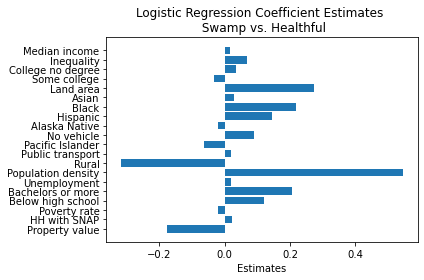

In [85]:
## plot coefficients for logit
fig, ax = plt.subplots()
ax.barh(x['Variable'],x['Logit Coef'], align='center')
ax.set_yticks(x['Variable'])
ax.invert_yaxis()  
ax.set_xlabel('Estimates')
ax.set_title('Logistic Regression Coefficient Estimates \n Swamp vs. Healthful')
plt.tight_layout()
plt.savefig('output/images/logit_swamp_healthful.png')

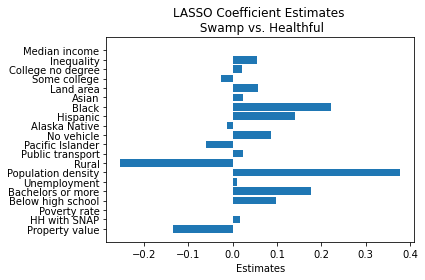

In [86]:
## plot lasso coefficient estimates
fig, ax = plt.subplots()
ax.barh(x['Variable'],x['Lasso Coef'], align='center')
ax.set_yticks(x['Variable'])
ax.invert_yaxis()  
ax.set_xlabel('Estimates')
ax.set_title('LASSO Coefficient Estimates \n Swamp vs. Healthful')
plt.tight_layout()
plt.savefig('output/images/lasso_swamp_healthful.png')

`Random Forest : oversampling`

In [87]:
## fit logistic model on resampled set
ada_model = RandomForestClassifier()
ada_model.fit(X_ada, y_ada)


RandomForestClassifier()

In [88]:
# examine classification errors
print('Accuracy:', ada_model.score(Xtest, ytest))
print('Recall:',recall_score(ytest, ada_model.predict(Xtest)))
confusion_matrix(ytest, ada_model.predict(Xtest))

Accuracy: 0.6709405462369369
Recall: 0.5128893662728249


array([[5730, 1933],
       [1814, 1910]])

In [89]:
## safe feature importance to dataframe
x=pd.DataFrame({'Variables':X_ada.columns, 'MDI':ada_model.feature_importances_})
x

,Variables,MDI
0,median_income,0.048948
1,inequality,0.050132
2,college_no_degree,0.049184
3,associates_degree,0.050135
4,log_SQMI,0.063651
5,log_perc_asian,0.048870
6,log_perc_black,0.068401
7,log_perc_hispanic,0.052635
8,log_perc_native,0.030489
9,log_perc_no_vehicle,0.057693


In [90]:
## rename variables
x=x.replace({'median_income':'Median income', 'inequality':'Inequality', 'college_no_degree':'College no degree', 'associates_degree':'Some college','log_SQMI': 'Land area', 'log_perc_asian': 'Asian', 'log_perc_black':'Black', 'log_perc_hispanic':'Hispanic', 'log_perc_native':'Alaska Native', 'log_perc_pacific':'Pacific Islander', 'log_perc_public_transport':'Public transport', 'log_perc_rural': 'Rural', 'log_pop_density':'Population density', 'log_perc_unemploy':'Unemployment', 'log_bach_or_more':'Bachelors or more', 'log_below_high_school':'Below high school', 'log_perc_pov':'Poverty rate', 'log_perc_snap':'HH with SNAP', 'log_value': 'Property value', 'log_perc_no_vehicle':'No vehicle'})

In [91]:
x=x.sort_values('MDI', ascending=False)
x

,Variables,MDI
13,Population density,0.070946
6,Black,0.068401
4,Land area,0.063651
9,No vehicle,0.057693
11,Public transport,0.056531
7,Hispanic,0.052635
18,HH with SNAP,0.051952
17,Poverty rate,0.051090
19,Property value,0.051059
3,Some college,0.050135


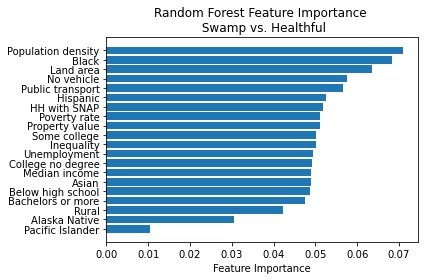

In [92]:
## plot lasso coefficient estimates
fig, ax = plt.subplots()
ax.barh(x['Variables'],x['MDI'], align='center')
ax.set_yticks(x['Variables'])
ax.invert_yaxis()  
ax.set_xlabel('Feature Importance')
ax.set_title('Random Forest Feature Importance \n Swamp vs. Healthful')
plt.tight_layout()
plt.savefig('output/images/rf_swamp_healthful.png')

In [93]:
## save overall accuracy and recall score from each model 
eval_2=pd.DataFrame({'Accuracy: RF':ada_model.score(Xtest, ytest), 'Recall: RF':recall_score(ytest,ada_model.predict(Xtest)), 'Accuracy:Lasso':ada_lasso.score(Xtest, ytest), 'Recall: Lasso':recall_score(ytest, ada_lasso.predict(Xtest)), 'Accuracy:Logit':ada_logit.score(Xtest, ytest), 'Recall: Logit':recall_score(ytest, ada_logit.predict(Xtest))}, index=[0])
eval_2

,Accuracy: RF,Recall: RF,Accuracy:Lasso,Recall: Lasso,Accuracy:Logit,Recall: Logit
0,0.670941,0.512889,0.61781,0.745166,0.61781,0.733888


**`Outcome 3: Desert vs. Swamp`**

In [94]:
## separate outcome from features
y=d_vs_s['desert']
X=d_vs_s.drop(columns=['desert'])
X.shape

(23721, 20)

In [95]:
# standardize features to eliminate issues of scaling
scaler = StandardScaler()
Xsc = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
Xsc.head(2)

,median_income,inequality,college_no_degree,associates_degree,log_SQMI,log_perc_asian,log_perc_black,log_perc_hispanic,log_perc_native,log_perc_no_vehicle,log_perc_pacific,log_perc_public_transport,log_perc_rural,log_pop_density,log_perc_unemploy,log_bach_or_more,log_below_high_school,log_perc_pov,log_perc_snap,log_value
0,0.610878,-1.265588,0.350975,-0.117801,0.054291,0.008843,0.407431,-0.195112,-0.123071,-0.136350,-0.223226,-1.010927,-0.601304,0.177627,-1.096155,0.859303,-1.258220,-0.798835,-0.767826,-0.014507
1,-0.145118,-0.546379,0.160387,-0.327244,1.877457,-0.563601,0.371147,-1.157170,0.376734,-0.718945,-0.223226,-1.010927,1.891937,-1.578548,0.230405,-0.561004,0.748195,-0.241436,0.520841,-0.654367


In [96]:
## split data; test size is 30%
Xtrain, Xtest, ytrain, ytest = train_test_split(Xsc, y, test_size=0.3, random_state=10)

**`Logistic Regression`**

In [97]:
## model fitting
logit = LogisticRegression()
logit.fit(Xtrain, ytrain)

LogisticRegression()

In [98]:
## examine classification errors
print('Accuracy:', logit.score(Xtest, ytest))
print('Recall:',recall_score(ytest, logit.predict(Xtest)))
confusion_matrix(ytest, logit.predict(Xtest))

Accuracy: 0.735843754390895
Recall: 0.6510894495412844


array([[2966,  663],
       [1217, 2271]])

**`LASSO Logistic Regression`**

In [100]:
##fit lasso logistic regression
lasso = LogisticRegression(penalty= 'l1', solver= 'liblinear',random_state=10)
lasso.fit(Xsc, y)

LogisticRegression(penalty='l1', random_state=10, solver='liblinear')

In [101]:
## specify range for alpha/C
C=np.arange(0.001,0.03,0.005)
C

array([0.001, 0.006, 0.011, 0.016, 0.021, 0.026])

#### Validation Curve: hyper parameter turning for strength of regularization penalty

In [102]:
## generate training and test scores using cv 10 fold
train_scores, test_scores = validation_curve(lasso, Xsc, y, param_name='C',
                                            param_range=C, cv=10)
train_scores


array([[0.71280682, 0.71015036, 0.70654363, 0.71656752, 0.71211766,
        0.70776149, 0.70584102, 0.71422549, 0.70986931, 0.71015036],
       [0.71800637, 0.71787906, 0.71211766, 0.7241557 , 0.71872219,
        0.71385077, 0.71338236, 0.72073633, 0.71581807, 0.71633332],
       [0.72067641, 0.72059581, 0.71361656, 0.726123  , 0.71998688,
        0.71736381, 0.71567755, 0.72214155, 0.71872219, 0.7194248 ],
       [0.72465805, 0.72382781, 0.71675488, 0.73029182, 0.72331257,
        0.72031477, 0.72040845, 0.72677877, 0.72143894, 0.72162631],
       [0.72746862, 0.72504567, 0.7181601 , 0.73207176, 0.72518619,
        0.72190735, 0.72120474, 0.72846503, 0.72279732, 0.72373413],
       [0.72812441, 0.72537355, 0.71890955, 0.73277437, 0.72635721,
        0.72209471, 0.72040845, 0.72991709, 0.72434306, 0.72424938]])

In [103]:
## compute mean train and test scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_mean

array([0.70498759, 0.70958325, 0.70857127, 0.71211257, 0.71346159,
       0.71392533])

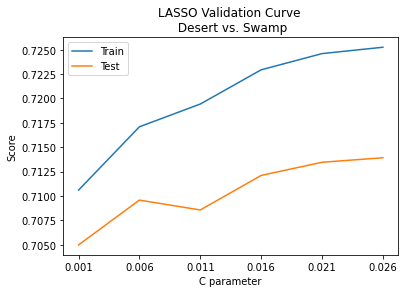

In [104]:
## plot curve
fig1 = plt.figure()
plt.plot(C, train_mean, label='Train')
plt.plot(C, test_mean, label='Test')
plt.xlabel('C parameter')
plt.ylabel('Score')
plt.title('LASSO Validation Curve \n Desert vs. Swamp')
plt.xticks(C)
plt.legend()
plt.savefig('output/images/valid_curve_lasso_desert_swamp.png')

Let's pick 0.001 to reduce variance . The higher test score associated with 0.006 is not worth the increase in variance.

In [105]:
##fit lasso logistic regression
lasso = LogisticRegression(C=0.001, penalty= 'l1', solver= 'liblinear',random_state=10)
lasso.fit(Xtrain, ytrain)

LogisticRegression(C=0.001, penalty='l1', random_state=10, solver='liblinear')

In [106]:
## examine classification errors
print('Accuracy:', lasso.score(Xtest, ytest))
print('Recall:',recall_score(ytest, lasso.predict(Xtest)))
confusion_matrix(ytest, lasso.predict(Xtest))

Accuracy: 0.7116762680904876
Recall: 0.5665137614678899


array([[3089,  540],
       [1512, 1976]])

In [107]:
x=pd.DataFrame({'Variable': Xsc.columns,'Logit Coef': logit.coef_.ravel(), 'Lasso Coef': lasso.coef_.ravel()})
x

,Variable,Logit Coef,Lasso Coef
0,median_income,0.251675,0.000000
1,inequality,-0.084262,0.000000
2,college_no_degree,0.015037,0.000000
3,associates_degree,0.065084,0.000000
4,log_SQMI,-1.333940,0.000000
5,log_perc_asian,-0.161279,0.000000
6,log_perc_black,-0.072003,0.000000
7,log_perc_hispanic,-0.251109,-0.087259
8,log_perc_native,0.026910,0.000000
9,log_perc_no_vehicle,-0.286081,-0.035112


In [108]:
## rename variables
x=x.replace({'median_income':'Median income', 'inequality':'Inequality', 'college_no_degree':'College no degree', 'associates_degree':'Some college','log_SQMI': 'Land area', 'log_perc_asian': 'Asian', 'log_perc_black':'Black', 'log_perc_hispanic':'Hispanic', 'log_perc_native':'Alaska Native', 'log_perc_pacific':'Pacific Islander', 'log_perc_public_transport':'Public transport', 'log_perc_rural': 'Rural', 'log_pop_density':'Population density', 'log_perc_unemploy':'Unemployment', 'log_bach_or_more':'Bachelors or more', 'log_below_high_school':'Below high school', 'log_perc_pov':'Poverty rate', 'log_perc_snap':'HH with SNAP', 'log_value': 'Property value', 'log_perc_no_vehicle':'No vehicle'})

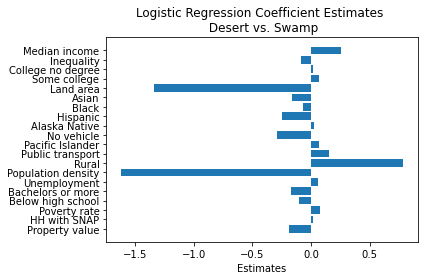

In [109]:
## plot coefficients for logit
fig, ax = plt.subplots()
ax.barh(x['Variable'],x['Logit Coef'], align='center')
ax.set_yticks(x['Variable'])
ax.invert_yaxis()  
ax.set_xlabel('Estimates')
ax.set_title('Logistic Regression Coefficient Estimates \n Desert vs. Swamp')
plt.tight_layout()
plt.savefig('output/images/logit_desert_swamp.png')

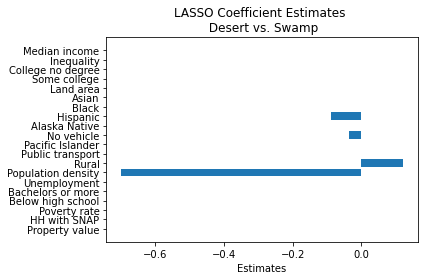

In [110]:
## plot lasso coefficient estimates
fig, ax = plt.subplots()
ax.barh(x['Variable'],x['Lasso Coef'], align='center')
ax.set_yticks(x['Variable'])
ax.invert_yaxis()  
ax.set_xlabel('Estimates')
ax.set_title('LASSO Coefficient Estimates \n Desert vs. Swamp')
plt.tight_layout()
plt.savefig('output/images/lasso_desert_swamp.png')

`Random Forest`

In [111]:
## model fitting
random_forest = RandomForestClassifier()
random_forest.fit(Xtrain, ytrain)

RandomForestClassifier()

In [112]:
## examine classification errors
print('Accuracy:', random_forest.score(Xtest, ytest))
print('Recall:',recall_score(ytest, random_forest.predict(Xtest)))
confusion_matrix(ytest, random_forest.predict(Xtest))

Accuracy: 0.7375298580862724
Recall: 0.6327408256880734


array([[3042,  587],
       [1281, 2207]])

In [113]:
## safe feature importance to dataframe
x=pd.DataFrame({'Variables':Xtrain.columns, 'MDI':random_forest.feature_importances_})
x

,Variables,MDI
0,median_income,0.043361
1,inequality,0.042442
2,college_no_degree,0.040651
3,associates_degree,0.040290
4,log_SQMI,0.106123
5,log_perc_asian,0.043058
6,log_perc_black,0.046877
7,log_perc_hispanic,0.062302
8,log_perc_native,0.020790
9,log_perc_no_vehicle,0.059680


In [114]:
## rename variables
x=x.replace({'median_income':'Median income', 'inequality':'Inequality', 'college_no_degree':'College no degree', 'associates_degree':'Some college','log_SQMI': 'Land area', 'log_perc_asian': 'Asian', 'log_perc_black':'Black', 'log_perc_hispanic':'Hispanic', 'log_perc_native':'Alaska Native', 'log_perc_pacific':'Pacific Islander', 'log_perc_public_transport':'Public transport', 'log_perc_rural': 'Rural', 'log_pop_density':'Population density', 'log_perc_unemploy':'Unemployment', 'log_bach_or_more':'Bachelors or more', 'log_below_high_school':'Below high school', 'log_perc_pov':'Poverty rate', 'log_perc_snap':'HH with SNAP', 'log_value': 'Property value', 'log_perc_no_vehicle':'No vehicle'})

In [115]:
x=x.sort_values('MDI', ascending=False)
x

,Variables,MDI
13,Population density,0.111195
4,Land area,0.106123
12,Rural,0.080786
7,Hispanic,0.062302
9,No vehicle,0.059680
19,Property value,0.049511
6,Black,0.046877
11,Public transport,0.046612
0,Median income,0.043361
5,Asian,0.043058


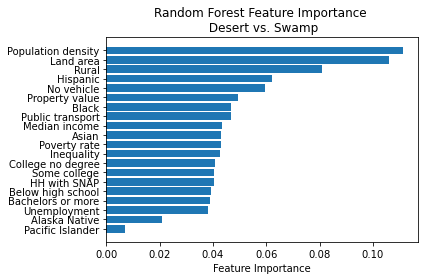

In [116]:
## plot lasso coefficient estimates
fig, ax = plt.subplots()
ax.barh(x['Variables'],x['MDI'], align='center')
ax.set_yticks(x['Variables'])
ax.invert_yaxis()  
ax.set_xlabel('Feature Importance')
ax.set_title('Random Forest Feature Importance \n Desert vs. Swamp')
plt.tight_layout()
plt.savefig('output/images/rf_desert_swamp.png')

In [117]:
## save overall accuracy and recall score from each model 
eval_3=pd.DataFrame({'Accuracy: RF':random_forest.score(Xtest, ytest), 'Recall: RF':recall_score(ytest,random_forest.predict(Xtest)), 'Accuracy:Lasso':lasso.score(Xtest, ytest), 'Recall: Lasso':recall_score(ytest, lasso.predict(Xtest)), 'Accuracy:Logit':logit.score(Xtest, ytest), 'Recall: Logit':recall_score(ytest, logit.predict(Xtest))}, index=[0])
eval_3

,Accuracy: RF,Recall: RF,Accuracy:Lasso,Recall: Lasso,Accuracy:Logit,Recall: Logit
0,0.73753,0.632741,0.711676,0.566514,0.735844,0.651089


**Complile and export evaluation scores from each model to csv format**

In [118]:
## rename index to differenciate evaluation scores
eval_1=eval_1.rename(index={0: "desert vs. healthful"})
eval_2=eval_2.rename(index={0: "swamp vs. healthful"})
eval_3=eval_3.rename(index={0: "desert vs. swamp"})

In [119]:
## concatenate and export
eval_combined=pd.concat([eval_1, eval_2, eval_3])
eval_combined.to_csv('output/tables/evaluation_scores.csv')

In [120]:
## view exported dataframe
eval_combined

,Accuracy: RF,Recall: RF,Accuracy:Lasso,Recall: Lasso,Accuracy:Logit,Recall: Logit
desert vs. healthful,0.673164,0.469771,0.585492,0.678912,0.583801,0.682962
swamp vs. healthful,0.670941,0.512889,0.617810,0.745166,0.617810,0.733888
desert vs. swamp,0.737530,0.632741,0.711676,0.566514,0.735844,0.651089


  `Plot ROC AUC`

In [121]:
## save logistic predictions to object
y_pred = logit.predict_proba(Xtest)

In [122]:
## generate true positives and false positives for KNN
false_positive_rate, true_positive_rate, thresholds = roc_curve(ytest, y_pred[:,1], pos_label=1)
logit_rates = pd.DataFrame(dict(fpr=false_positive_rate, tpr=true_positive_rate))
logit_auc = auc(logit_rates['fpr'], logit_rates['tpr'])
print('Logistic Regression AUC: ', logit_auc)

Logistic Regression AUC:  0.814279987789494


In [123]:
## save lasso predictions to object
y_pred = lasso.predict_proba(Xtest)

In [124]:
## generate true positives and false positives for log_reg
false_positive_rate, true_positive_rate, thresholds = roc_curve(ytest, y_pred[:,1], pos_label=1)
lasso_rates = pd.DataFrame(dict(fpr=false_positive_rate, tpr=true_positive_rate))
lasso_auc = auc(lasso_rates['fpr'], lasso_rates['tpr'])
print('LASSO AUC: ', lasso_auc)

LASSO AUC:  0.7875037762822927


In [125]:
## save NB predictions to object
y_pred = random_forest.predict_proba(Xtest)

In [126]:
## generate true positives and false positives for NB
false_positive_rate, true_positive_rate, thresholds = roc_curve(ytest, y_pred[:,1], pos_label=1)
random_forest_rates = pd.DataFrame(dict(fpr=false_positive_rate, tpr=true_positive_rate))
random_forest_auc = auc(random_forest_rates['fpr'], random_forest_rates['tpr'])
print('Random Forest AUC: ', random_forest_auc)

Random Forest AUC:  0.8244786360384366


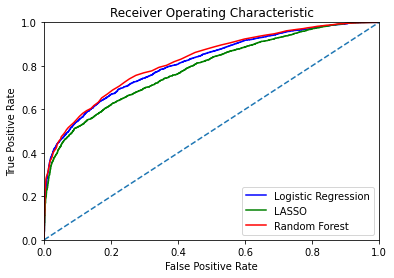

In [127]:
## plot ROC for KNN, log-reg, and NB
fig3 = plt.figure()
plt.plot(logit_rates.fpr, logit_rates.tpr, 'b', label = 'Logistic Regression')
plt.plot(lasso_rates.fpr, lasso_rates.tpr, 'g', label = 'LASSO')
plt.plot(random_forest_rates.fpr, random_forest_rates.tpr, 'r', label = 'Random Forest')
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()